## Problem 1: Visualise data in a static map (10 points)


Create a *static* **thematic map** using the skills you learnt during lesson 5. The map should <br>
contain more than one layer (from at least two different data sets). Pay attention to classification <br>
and visualisation (appropriate colour scheme choice, etc.). Write your code in this notebook, and <br>
store the resulting maps in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder.

### Topic of the map

- Use any of the data sets we have used during the course (travel time data, population grid), or <br>
  any other data set of your interest (for example, [open data sets from Statistics Finland](https://www.stat.fi/org/avoindata/index_en.html), <br>
  or the open geo-data from [the Helsinki Region Infoshare](https://hri.fi/en)). If you download <br>
  data sets, add, commit, and push them to the `DATA_DIRECTORY`. Be sure to include an attribution <br>
  to each data set in your output map!
- Feel free to start from and adapt examples from the course material! You can take one step further <br>
  and add additional analysis to, e.g., the shopping centre dominance or the population within vincinity <br>
  of certain addresses)

### Criteria

- The map has more than one data layer (for instance, the results of an analysis, and the road network <br>
  to illustrate a complex spatial pattern). If (and only if) you think it adds additional value, feel <br>
  free to add a base map (but a base map does not count as an own layer)
- The map portrays the output of an analysis or a classification that adds value beyond just displaying <br>
  the raw data
- The map follows good cartographic practices (appropriate map extent and zoom level, colour scheme, <br>
  legend and data sources, etc.)

### Output

- Save the map(s) in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder, remember to add, commit, <br>
  and push them to the GitHub repository
- Remember to also add, commit, and push input data sets and code

---

In [20]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
OUTPUT_DIRECTORY = NOTEBOOK_PATH / "docs"

In [21]:
# ADD YOUR OWN CODE HERE

In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx
from shapely.ops import nearest_points
from shapely.geometry import LineString, MultiLineString
import networkx as nx
import matplotlib.pyplot as plt

In [23]:
# The walking time to Tung Chung Station in Tung Chung New Town

In [24]:
# Plan
# 1. For each building find the walking time to each MTR station
# 2. For each building find the MTR station with minimum walking time
# 3. Assign each building with color respect to the MTR station color

In [25]:
# 1a. For each building polygon, find the nearest point to the pedestrian_route in the building polygon and the pedestrian_route 
# 1b. Connect these 2 points to form new LineString

In [26]:
PEDESTRIAN_DIRECTORY = DATA_DIRECTORY / "3D_Pedestrian_Network"
BUILDING_DIRECTORY = DATA_DIRECTORY / "Buildings"
BOUNDARIES_DIRECTORY = DATA_DIRECTORY / "New_Towns_Boundaries"

In [27]:
pedestrian_route = gpd.read_file(PEDESTRIAN_DIRECTORY / "PedestrianRoute.geojson")
pedestrian_route_related_buildings = pd.read_json(PEDESTRIAN_DIRECTORY / "PedRouteRelBldgPoly.json")
buildings = gpd.read_file(BUILDING_DIRECTORY / "Building_Footprint_qgis.gpkg")
new_town_boundaries = gpd.read_file(BOUNDARIES_DIRECTORY / "Boundaries-of-New-Towns.geojson")

In [64]:
CRS_EPGS_CODE = "EPSG:3857"

In [29]:
# Let us convert the dataframe into EPSG: 3857
pedestrian_route = pedestrian_route.to_crs(CRS_EPGS_CODE)
buildings = buildings.to_crs(CRS_EPGS_CODE)
new_town_boundaries = new_town_boundaries.to_crs(CRS_EPGS_CODE)

In [30]:
assert pedestrian_route.crs == buildings.crs == new_town_boundaries.crs, "The GeoDataFrames have different CRS"
#assert pedestrian_route.crs.name == "Hong Kong 1980 Grid System", "The CRS of the GeoDataFrame is not EPSG:2326"

In [31]:
# Before any operation lets make the GeoDataFrames smaller to process faster

In [32]:
tc_boundary = new_town_boundaries[new_town_boundaries["NEWTOWN_EN"]=="Tung Chung"]

In [33]:
pedestrian_route_tc = pedestrian_route.overlay(tc_boundary, how="intersection")
buildings_tc = buildings.overlay(tc_boundary, how="intersection")

In [34]:
pedestrian_route_dissolved = pedestrian_route_tc.dissolve()
pedestrian_route_dissolved = pedestrian_route_dissolved[["geometry"]]

In [35]:
blds_route_conn = buildings_tc["geometry"].apply(lambda polygon: 
                            LineString(
                                nearest_points(polygon, pedestrian_route_dissolved.at[0, "geometry"]
                                              )))

In [36]:
blds_route_conn_list = []
blds_nearest_route_pt = []
for polygon in buildings_tc.geometry:
    nearest_pt_pair = nearest_points(polygon, pedestrian_route_dissolved.at[0, "geometry"])
    bld_route_conn = LineString([nearest_pt_pair[0], nearest_pt_pair[1]])
    blds_nearest_route_pt.append(nearest_pt_pair[0])
    blds_route_conn_list.append(bld_route_conn)
buildings_tc["nearest_route_pt"] = blds_nearest_route_pt

/home/jordan/anaconda3/envs/autogis/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [37]:
blds_route_conn = gpd.GeoDataFrame({"geometry": blds_route_conn_list}, crs=CRS_EPGS_CODE)

In [38]:
pdr_disolved_merged = pedestrian_route_dissolved.union(blds_route_conn.dissolve())

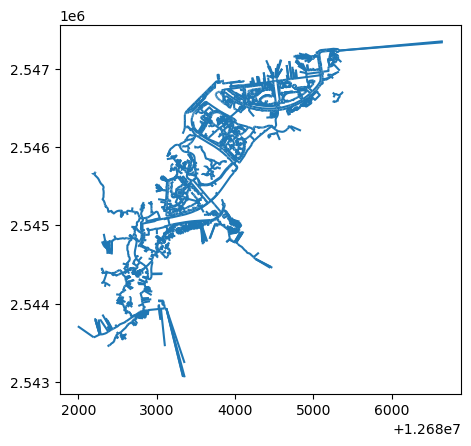

In [39]:
pdr_dm_ax = pdr_disolved_merged.plot()

We then need to find the coordinate of the Tung Chung MTR station, we can achieve this by geocoding:

In [40]:
tc_station_geocoded = gpd.tools.geocode(
    ["Tung Chung Station"],
    provider="nominatim",
    user_agent="autogis2022"
)

In [41]:
tc_station_geocoded = tc_station_geocoded.to_crs(CRS_EPGS_CODE)
assert tc_station_geocoded.crs == buildings.crs

In [42]:
tc_station_network_nearest_pts = nearest_points(tc_station_geocoded.geometry[0], pdr_disolved_merged.geometry[0])

In [43]:
tc_station_nearest_pt = tc_station_network_nearest_pts[0]
network_nearest_tc_station_pt = tc_station_network_nearest_pts[1]

In [44]:
tc_station_geocoded["nearest_route_pt"] = [tc_station_nearest_pt]

/home/jordan/anaconda3/envs/autogis/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [45]:
pdr_disolved_merged = pdr_disolved_merged.union(LineString([tc_station_nearest_pt, network_nearest_tc_station_pt]))

Then for each building we can find the shortest distance to the railway station:

In [46]:
graph = nx.Graph()
for point in buildings_tc.nearest_route_pt:
    graph.add_node(point)

TypeError: unhashable type: 'Point'

Looks like we cannot create networkx graph from shapely polygon and lines. First let create the networkx graph from shapely polygon via momepy:

In [47]:
new_line_list = []
for line in pdr_disolved_merged[0]:
    new_line = LineString(tuple(zip(line.xy[0], line.xy[1])))
    new_line_list.append(new_line)
pdf_dm_no_z = MultiLineString(new_line_list)

/tmp/ipykernel_33994/1138526651.py:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in pdr_disolved_merged[0]:


In [48]:
gpd_pdr_dm=gpd.GeoDataFrame({"geometry": pdf_dm_no_z}, crs=CRS_EPGS_CODE)

In [49]:
import momepy
graph = momepy.gdf_to_nx(gpd_pdr_dm)

/home/jordan/anaconda3/envs/autogis/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then we need to convert the shapely point to something to add the graph:

In [50]:
graph.add_node((tc_station_geocoded.geometry[0].x, tc_station_geocoded.geometry[0].y))

In [51]:
for pt in buildings_tc.nearest_route_pt:
    graph.add_node((pt.x, pt.y))

Then the shortest distance from each building to Tung Chung MTR buildings_tc["to_mtr_sd"] can with obtain by nx.shortest_path_length() with the input of graph, starting node buildings_tc["nearest_route_pt"] and tc_station_geocoded["nearest_route_pt"]

In [52]:
shortest_distance_list = []
for pt in buildings_tc["nearest_route_pt"]:
    source = (pt.x, pt.y)
    target = (tc_station_geocoded["nearest_route_pt"][0].x, tc_station_geocoded["nearest_route_pt"][0].y)
    if(nx.has_path(graph, source, target)):
        shortest_distance = nx.shortest_path_length(graph, source=source, target=target)
    else:
        shortest_distance = np.nan
    shortest_distance_list.append(shortest_distance)
buildings_tc["to_mtr_sd"] = shortest_distance_list

Let take the average human walking speed as 1.4m/s

In [53]:
buildings_tc["to_mtr_st"] = (buildings_tc["to_mtr_sd"] / 1.4) / 60

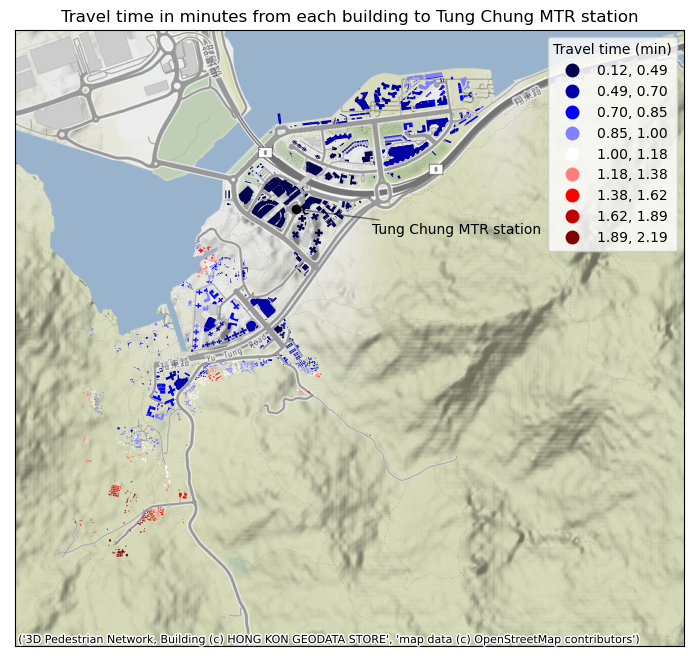

In [62]:
ax = buildings_tc.plot(
    column="to_mtr_st", 
    scheme="Natural_Breaks", 
    k=9, cmap="seismic", 
    linewidth=0, 
    legend=True,
    figsize=(12, 8),
    legend_kwds={"title": "Travel time (min)"}
)
ax.annotate(
    text="Tung Chung MTR station",
    xy=(
        tc_station_geocoded.geometry[0].xy[0][0],
        tc_station_geocoded.geometry[0].xy[1][0]
    ),
    xytext=(
        12684500, #812500 for EPSG:2326
        2546000  #816500
    ),
    arrowprops=dict(
        arrowstyle="->",
        alpha=0.5
    )
)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_title("Travel time in minutes from each building to Tung Chung MTR station")
tc_station_geocoded.plot(ax=ax, legend=True, color="black")
cx.add_basemap(
    ax,
    attribution=(
        "3D Pedestrian Network, Building (c) HONG KON GEODATA STORE",
        "map data (c) OpenStreetMap contributors"
    )
)

In [63]:
ax.figure.savefig(OUTPUT_DIRECTORY / "travel_time_in_minutes_to_tung_chung_mtr_station.png")